### Hidden Markov Model

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
import yfinance as yf

start = '2000-01-01'
end = '2024-02-26'
ticker = '^GSPC'
data = yf.download(ticker, start = start, end = end)

[*********************100%%**********************]  1 of 1 completed


In [3]:
data['price_diff'] = data.Close.pct_change()

In [4]:
data.dropna(inplace = True)

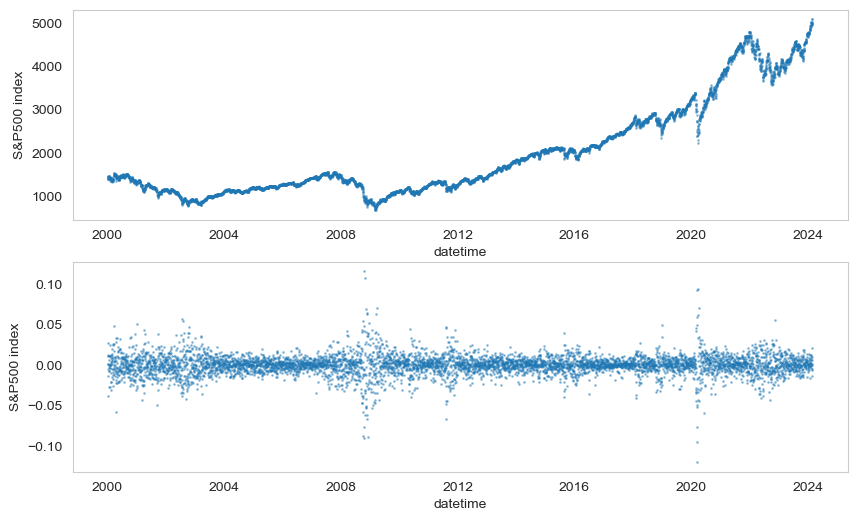

In [5]:
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.scatter(data.index, data["Close"], alpha = 0.4, marker = '.', s = 4)
plt.xlabel("datetime")
plt.ylabel("S&P500 index")
plt.grid(False)
plt.subplot(2,1,2)
plt.scatter(data.index, data["price_diff"], alpha = 0.4, marker = '.', s = 4)
plt.xlabel("datetime")
plt.ylabel("S&P500 index")
plt.grid(False)
plt.show()

We fit the daily change in S&P500 index to a Gaussian emissions model with 3 hidden states. The reason for using 3 hidden states is that we expect at the very least 3 different regimes in the daily changes — low, medium and high votality.

In [41]:
X_train, X_test = data[['price_diff']][:'2019'].values, data[['price_diff']]['2020':].values # use numpy ndarray

Build the Hidden Markov Model

In [42]:
model = hmm.GaussianHMM(
    n_components = 3, 
    covariance_type = 'diag',
    n_iter = 50,
    random_state = 42
)
model.fit(X_train)

GaussianHMM(n_components=3, n_iter=50, random_state=42)

Predict hidden states $Z_t$ corresponding to observed data

In [43]:
Z_train = model.predict(X_train)

In [44]:
states_train = pd.unique(Z_train)

We find that the model does indeed return 3 unique hidden states. These numbers do not have any intrinsic meaning —which state corresponds to which **volatility regime** must be confirmed by looking at the model parameters.

In [45]:
print(states_train)

[2 0 1]


We find that for this particular data set, the model will almost always start in state 1.

In [46]:
print("Start probabilities:", model.startprob_)

Start probabilities: [6.13672028e-285 2.08831153e-211 1.00000000e+000]


The transition matrix for the 3 hidden states show that the diagonal elements are large compared to the off diagonal elements. This means that the model tends to want to remain in that particular state it is in — the probability of transitioning up or down is not high.

In [47]:
print("Transition matrix \n", model.transmat_)

Transition matrix 
 [[9.28967875e-03 9.90704073e-01 6.24805268e-06]
 [9.50192039e-01 3.60626902e-02 1.37452711e-02]
 [1.31948638e-02 7.04107107e-03 9.79764065e-01]]


Finally, we take a look at the Gaussian emission parameters

Remember that each observable is drawn from a multivariate Gaussian distribution. For state 0, the Gaussian mean is 1.28, for state 1 it is 0.41 and for state 2 it is -0.02.

In [48]:
print("Gaussian distribution means:")
print(model.means_)

Gaussian distribution means:
[[ 1.26221170e-03]
 [ 7.87193248e-05]
 [-9.74855118e-04]]


We also have the Gaussian covariances. Note that because our data is 1 dimensional, the covariance matrices are reduced to scalar values, one for each state. For state 0, the covariance is 62.4, for state 1 it is 230.9 and for state 2 it is 2018.55. This seems to agree with our initial assumption about the 3 volatility regimes — for low volatility the covariance should be small, while for high volatility the covariance should be very large.

In [49]:
print("Gaussian distribution covariances:")
print(model.covars_)

Gaussian distribution covariances:
[[[4.96547683e-05]]

 [[6.60253513e-05]]

 [[3.93512216e-04]]]


plotting the model's state prediction with the data

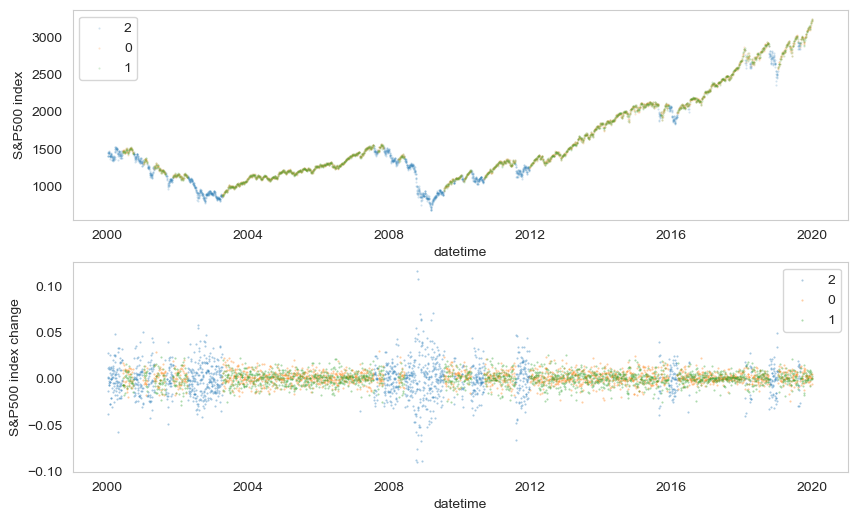

In [50]:
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
for i in states_train:
    want = (Z_train == i)
    x = data[:'2019'].index[want]
    y = data["Close"][:'2019'].iloc[want]
    plt.scatter(x, y, marker = '.', s = 1, alpha = 0.2)
plt.legend(states_train)
plt.grid(False)
plt.xlabel("datetime")
plt.ylabel("S&P500 index")
plt.subplot(2,1,2)
for i in states_train:
    want = (Z_train == i)
    x = data[:'2019'].index[want]
    y = data["price_diff"][:'2019'].iloc[want]
    plt.scatter(x, y, marker = '.', s = 1, alpha = 0.4)
plt.legend(states_train)
plt.grid(False)
plt.xlabel("datetime")
plt.ylabel("S&P500 index change")
plt.show()

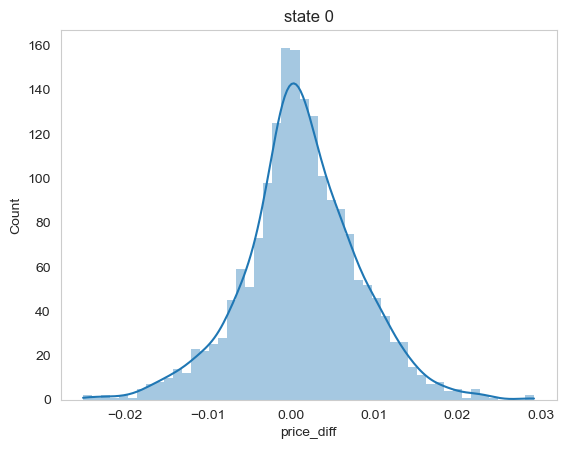

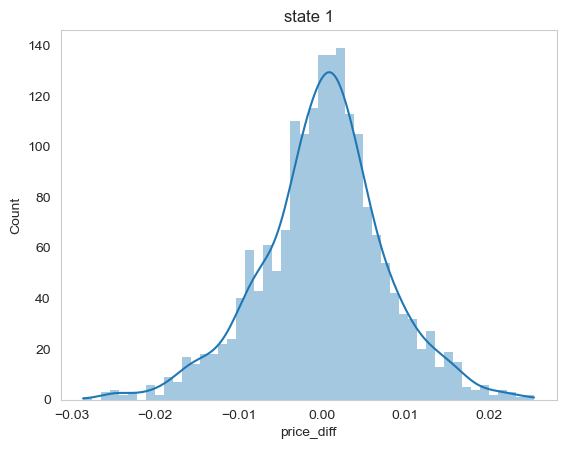

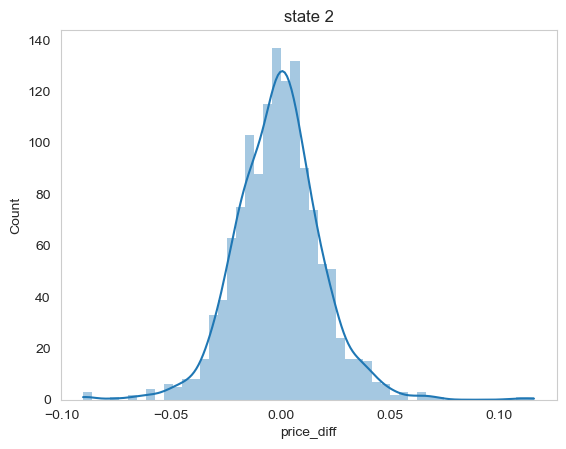

In [51]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.histplot(
    data['price_diff'][:'2019'].iloc[Z_train == 0],
    bins = 50,
    edgecolor = 'none',
    alpha = 0.4,
    kde = True
)
plt.title('state 0')
plt.grid(False)
plt.show()
sns.histplot(
    data['price_diff'][:'2019'].iloc[Z_train == 1],
    bins = 50,
    edgecolor = 'none',
    alpha = 0.4,
    kde = True
)
plt.title('state 1')
plt.grid(False)
plt.show()
sns.histplot(
    data['price_diff'][:'2019'].iloc[Z_train == 2],
    bins = 50,
    edgecolor = 'none',
    alpha = 0.4,
    kde = True
)
plt.title('state 2')
plt.grid(False)
plt.show()

In [52]:
Z_test = model.predict(X_test)
states_test = pd.unique(Z_test)

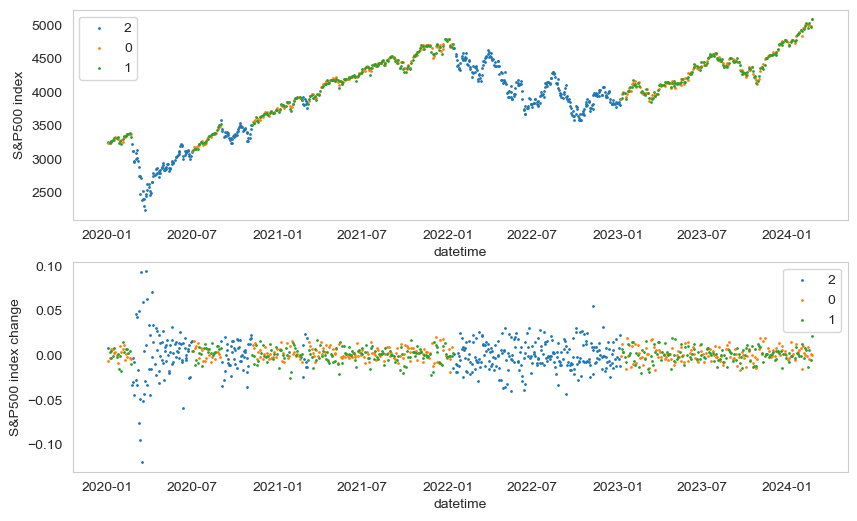

In [53]:
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
for i in states_test:
    want = (Z_test == i)
    x = data['2020':].index[want]
    y = data["Close"]['2020':].iloc[want]
    plt.scatter(x, y, marker = 'o', s = 1)
plt.legend(states_train)
plt.grid(False)
plt.xlabel("datetime")
plt.ylabel("S&P500 index")
plt.subplot(2,1,2)
for i in states_test:
    want = (Z_test == i)
    x = data['2020':].index[want]
    y = data["price_diff"]['2020':].iloc[want]
    plt.scatter(x, y, marker = 'o', s = 1)
plt.legend(states_test)
plt.grid(False)
plt.xlabel("datetime")
plt.ylabel("S&P500 index change")
plt.show()

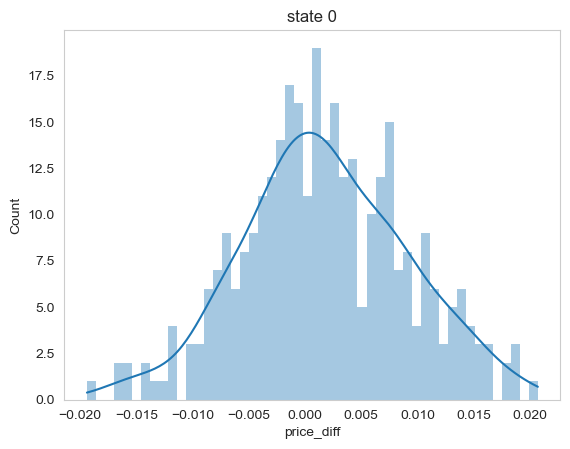

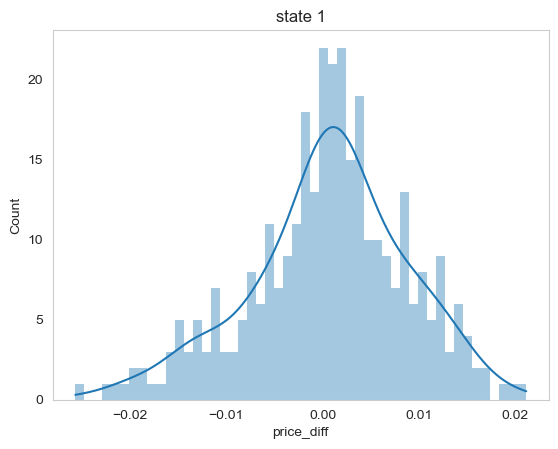

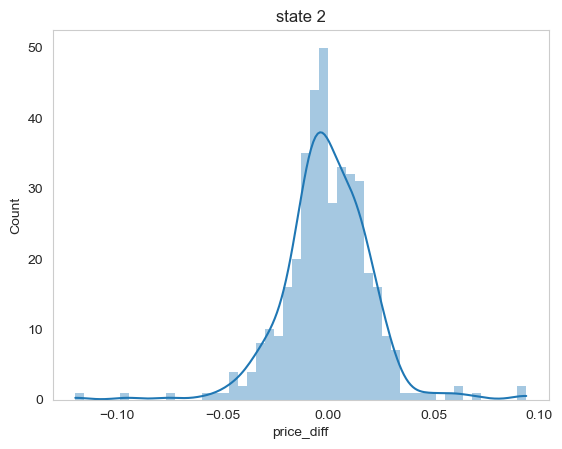

In [54]:
sns.histplot(
    data['price_diff']['2020':].iloc[Z_test == 0],
    bins = 50,
    edgecolor = 'none',
    alpha = 0.4,
    kde = True
)
plt.title('state 0')
plt.grid(False)
plt.show()
sns.histplot(
    data['price_diff']['2020':].iloc[Z_test == 1],
    bins = 50,
    edgecolor = 'none',
    alpha = 0.4,
    kde = True
)
plt.title('state 1')
plt.grid(False)
plt.show()
sns.histplot(
    data['price_diff']['2020':].iloc[Z_test == 2],
    bins = 50,
    edgecolor = 'none',
    alpha = 0.4,
    kde = True
)
plt.title('state 2')
plt.grid(False)
plt.show()

### Conclusion

It seems to be available for investment strategies using regime-shifting labeling and Bayesian modeling